# Project Description

<ul>
    
<li>
    <b>Introduction</b>   
    <p>
    This project analyzes tweets about Local Defence Units (LDUs) in Uganda.
    </p>
</li>
<br></br>
<li>
    <b>Background</b>   
    <p>
    Local Defence Units (LDUs) are personnel recruited by the Uganda People's Defence Forces (UPDF)
        to beef up the police, army and other security agencies in policing work across the country.
    </p>
</li>
<br></br>
<li>
    <b>Motivation</b>   
    <p>
    There is a growing concern about police brutality as cases of LDU killings and violence increase. 
        Many have used twitter as a platform to raise concerns, have their voices be heard and push for reform. 
        The purpose of this project is to analyze the sentiment behind these tweets
    </p>
</li>
<br></br>
<li>
    <b>Resources</b>   
    <ol>
        <li>Niek Sanders’ Corpus
            <p>
                This project leverages Niek Sanders’ Corpus of over 5000 hand-classified tweets 
                to train the classifier.
            </p>
        </li>
        <br></br>
        <li>Twitter API
            <p>
                This project leverages the Twitter API to access and retrieve a little short 
                of 2000 tweets that are analyzed and classified.
            </p>
        </li>
        <br></br>
        <li>Python Libraries
            <p>
                This project leverages multiple native and non-native python libraries to 
                analyze text (polarity & subjectivity), generate plots and statistics (common words), 
                and classify tweets as either positive or negative using a Naive Bayes classifier.
            </p>
        </li>
    </ol>
</li>

</ul>

<br></br>

<br></br>

In [1]:
#Import the necessary libraries

import matplotlib.pyplot as plt
import pandas  as pd
import preprocessor as p
import pickle
import twitter
import string
import nltk
from nltk.classify import NaiveBayesClassifier
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [2]:
#Define helper functions


def get_next_results_id(search):
    """
    Return the id (max_id) for the next search results.
    
    The max_id of the next search results is the
    lowest id less by one of the current search
    results.
    
    The function loops through all reuslt ids
    and returns the lowest id.
    """
    
    ids = []
    for status in search['statuses']:
        ids.append(status['id'])
    
    return min(ids)-1


def get_polarity(tweet):
    """
    Returns the polarity of a text string.
    """
    
    text = TextBlob(tweet)
    return text.sentiment.polarity


def get_subjectivity(tweet):
    """
    Returns the subjectivity of
    a text string.
    """
    
    text = TextBlob(tweet)
    return text.sentiment.subjectivity


def bag_of_words(words):
    """
    Performs a check on all words in a tweet against
    the training data.
    
    Assigns a label 1 if the word is in the training data
    otherwise assigns label 0.
    
    Returns a dictionary of word:label --> key:value pairs.
    """
    
    return {word:(word in training_data)*1 for word in words 
            if not word.lower() in useless_words}


def tokenize(data):
    """
    Generalizes the tokenization function.
    
    Returns a list of all words in a text string.
    """
    
    return [nltk.word_tokenize(text) for text in data.tolist()]

In [3]:
#Load the twitter authentication credentials

Twitter = pickle.load(open('./secret_twitter_credentials.pkl', 'rb'))

In [4]:
#Authenticate and access the api

auth = twitter.oauth.OAuth(Twitter['Access Token'],
                           Twitter['Access Token Secret'],
                           Twitter['Consumer Key'],
                           Twitter['Consumer Secret'])

twitter_api = twitter.Twitter(auth=auth)

In [5]:
#Search and retrieve tweets

statuses = []
query = 'ldu'
search = twitter_api.search.tweets(q=query, geocode='1.3733,32.2903,10000mi', count=100)

statuses.extend(search['statuses'])

#Repeat the search to get the 19 subsequent 100 results
for phase in range(19):
    search = twitter_api.search.tweets(q=query, count=100, geocode='1.3733,32.2903,10000mi',
                                   max_id = get_next_results_id(search))
    
    statuses.extend(search['statuses'])

In [6]:
#Filter out unique tweets

tweet_text = []
for status in statuses:
    if not p.clean(status["text"]) in tweet_text:
        tweet_text.append(p.clean(status["text"]))

print('----------------------------------------')
print('Number of retrieved tweets:\t', len(statuses))
print('----------------------------------------')
print('Number of unique tweets:\t', len(tweet_text))
print('----------------------------------------')

----------------------------------------
Number of retrieved tweets:	 1874
----------------------------------------
Number of unique tweets:	 791
----------------------------------------


In [7]:
#Store the tweets in a table

test_set = pd.DataFrame(data=tweet_text, columns=['TweetText'])
test_set['Polarity'] = test_set['TweetText'].apply(get_polarity)
test_set['Subjectivity'] = test_set['TweetText'].apply(get_subjectivity)

In [8]:
#Preview

test_set.head()

,TweetText,Polarity,Subjectivity
0,: The problem isnt that they are poorly traine...,-0.45,0.75
1,: Abaserikale b'eggye kuuma byalo (LDU) abazen...,0.00,0.00
2,"So what you're saying is, if we find any LDU o...",0.00,0.00
3,LDU in animal portrait,0.00,0.00
4,: The lawyers' group has asked Parliament to e...,0.00,0.00


In [9]:
#Generate descriptive statistics about the polarity and subjectivity of the data

test_set.describe().T

,count,mean,std,min,25%,50%,75%,max
Polarity,791.0,0.013020,0.260556,-1.0,0.0,0.000000,0.0,1.0
Subjectivity,791.0,0.256772,0.312617,0.0,0.0,0.066667,0.5,1.0


### Notes:

<ol>
    <li><b>Subjectivity</b>
        <p>
            Reflects the extent to which text is opinionated. 
            The lowest score is 0, reflecting that it could very much be fact. 
            The highest score is 1, reflecting that it could very much be opinion.
        </p>
    </li>
    <br></br>
    <li><b>Polarity</b>
        <p>
            Reflects sentiment orientation i.e the extent to which text is positive or negative. 
            The highest negative score is -1. 
            The highest positive score is 1.
        </p>
    </li>
</ol>

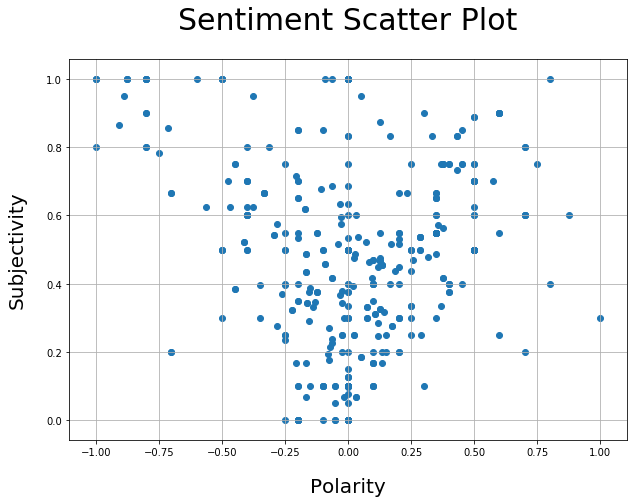

In [10]:
#Plot a scatter plot of polarity vs. subjectivity

plt.figure(figsize=(10,7))
plt.scatter(test_set['Polarity'], test_set['Subjectivity'])
plt.title(label='Sentiment Scatter Plot', size=30, pad=30)
plt.xlabel(xlabel='Polarity', size=20, labelpad=20)
plt.ylabel(ylabel='Subjectivity', size=20, labelpad=20)
plt.tick_params(labelsize=10)
plt.autoscale()
plt.grid('on')
plt.show()

In [11]:
#Check the correlation of the features

test_set['Polarity'].corr(test_set['Subjectivity'])

-0.028258334925231943

In [12]:
#Import the train set

training_set = pd.read_csv('./twitter-dataset/full-corpus.csv')
training_set['TweetText'] = training_set['TweetText'].apply(p.clean)

In [13]:
#Preview

training_set.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all has to do is get swype on the iphone a...
1,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious video - guy does a duet with 's Siri...
2,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,you made it too easy for me to switch to iPhon...
3,apple,positive,126379685453119488,Tue Oct 18 19:30:39 +0000 2011,The strangest things Siri has said so far. I a...
4,apple,positive,126377656416612353,Tue Oct 18 19:22:35 +0000 2011,Great up close & personal event tonight in Reg...


In [14]:
#List of things irrelevant to the analysis such as articles, pronouns and punctuation marks

useless_words = list(string.punctuation)+nltk.corpus.stopwords.words('english')

In [15]:
#Curate the training and test features for the classifier

training_data = nltk.word_tokenize(' '.join(training_set['TweetText'].tolist()))
test_data = tokenize(test_set['TweetText'])

positive_tweets = tokenize(training_set[training_set['Sentiment'].str.contains('positive')]['TweetText'])
negative_tweets = tokenize(training_set[training_set['Sentiment'].str.contains('negative')]['TweetText'])

positive_features = [(bag_of_words(tweet), 'positive') 
                     for tweet in positive_tweets]

negative_features = [(bag_of_words(tweet), 'negative') 
                     for tweet in negative_tweets]

training_features = positive_features + negative_features

test_features = [(bag_of_words(tweet), None) 
                 for tweet in test_data]

In [16]:
#Get the frequency of all the words from the test set (retrieved tweets)

test_set_words = [word for word in ' '.join(test_set['TweetText']).split() 
                  if not word.lower() in useless_words]

word_count = Counter(test_set_words)

In [17]:
#View the 30 most common words

word_count.most_common()[:30]

[('LDU', 421),
 ("LDU's", 65),
 ('people', 47),
 ('police', 36),
 ('us', 36),
 ('Ugandans', 31),
 ('Uganda', 28),
 ('u', 28),
 ('one', 28),
 ('UPDF', 27),
 ('killed', 26),
 ('guys', 26),
 ('LDUs', 24),
 ('think', 24),
 ('like', 24),
 ('know', 23),
 ('Police', 23),
 ('LDU.', 22),
 ('Local', 21),
 ('back', 19),
 ('must', 19),
 ('life', 18),
 ('kill', 18),
 ('killing', 18),
 ('get', 17),
 ('boda', 17),
 ('hands', 17),
 ('officers', 17),
 ('see', 17),
 ('disband', 16)]

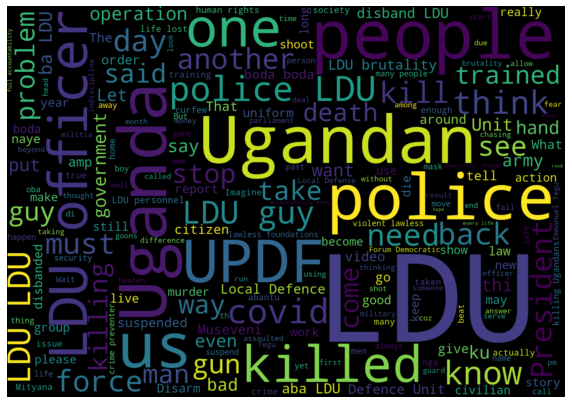

In [18]:
#Generate a word cloud for the words associated with the tweets

word_cloud = WordCloud(width=2000, height=1400, random_state=21)
plt.figure(figsize=(10,10))
plt.imshow(word_cloud.generate(' '.join(test_set_words)), interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
#Build and train the sentiment classifier

sentiment_classifier = NaiveBayesClassifier.train(training_features)

In [20]:
#Classify the tweets

labels = [sentiment_classifier.classify(feature[0]) for feature in test_features]

In [21]:
#Print the results

positive = labels.count('positive')
negative = labels.count('negative')
positive_percentage = (positive/len(labels))*100
negative_percentage = (negative/len(labels))*100

print('----------------------------------------')
print('Number of positive tweets:\t', positive)
print('Percentage of positive tweets:\t', positive_percentage)
print('Number of negative tweets:\t', negative)
print('Percentage of negative tweets:\t', negative_percentage)
print('----------------------------------------')

if positive > negative:
    print('Overall positive sentiment')
else:
    print('Overall negative sentiment')

----------------------------------------
Number of positive tweets:	 186
Percentage of positive tweets:	 23.514538558786345
Number of negative tweets:	 605
Percentage of negative tweets:	 76.48546144121366
----------------------------------------
Overall negative sentiment


In [22]:
#Check classifier accuracy on seen data

nltk.classify.util.accuracy(sentiment_classifier,training_features)*100

98.06763285024155

<br></br>

<br></br>

## Info:

<ul>
    <li>Author:
        Alvin Nahabwe
    </li>
    <br></br>
    <li>Date:
        7/17/2020 1:30 PM
    </li>
    <br></br>
    <li>Email:
        alvin.n256@gmail.com
    </li>
    <br></br>
    <li>Github:
        <a href="https://www.github.com/Alvin-Nahabwe">GitHub</a>
    </li>
    <br></br>
    <li>Linkedin:
        <a href="https://www.linkedin.com/in/alvin-nahabwe">LinkedIn</a>
    </li>
</ul>